In [1]:
import os
import sys
sys.path.append("../NeuralTSNE/") # Comment out this line if you have NeuralTSNE installed.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import NeuralTSNE as ntsne

from torch.utils.data import TensorDataset, random_split
from pytorch_lightning.callbacks import EarlyStopping, RichProgressBar
from pytorch_lightning import Trainer, seed_everything

torch.set_float32_matmul_precision("high")

%matplotlib inline

The dataset is alanine dipeptide in vaccum, available to download from https://zenodo.org/records/4756093 (`Data-ala1/ala1-vaccum-pt/Ala1-PT.repl0/colvar.0.data`. Features are 45 pairwise distances between heavy atoms. 

Detailed information about the dataset is described in *Multiscale Reweighted Stochastic Embedding (MRSE): Deep Learning of Collective Variables for Enhanced Sampling* (https://doi.org/10.1021/acs.jpca.1c02869).

The dataset contains also time, energy, and the dihedral angles phi, psi, and theta. These will not be used for training.

In [2]:
!head -n 1 data/adp-feat-dist.data

#! FIELDS time energy phi psi theta d1 d2 d3 d4 d5 d6 d7 d8 d9 d10 d11 d12 d13 d14 d15 d16 d17 d18 d19 d20 d21 d22 d23 d24 d25 d26 d27 d28 d29 d30 d31 d32 d33 d34 d35 d36 d37 d38 d39 d40 d41 d42 d43 d44 d45


In [3]:
data = np.loadtxt('data/adp-feat-dist.data')

Use only the distances for learning (labeled as d* in the above header). 

In [4]:
X = data[:, 5:]

In [5]:
X.shape

(100001, 45)

_Prepare the training and validation data._

The validation dataset will be 20% of the total number of samples.

In [6]:
X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X)

valid = 0.2
n = len(dataset)
n_train = int((1.0 - valid) * n)
n_valid = n - n_train
train_dataset, valid_dataset = random_split(dataset, [n_train, n_valid])

_Initialize a neural network to perform dimensionality reduction._

The neural network will perform reduction from 45 to 2 dimensions.

In [7]:
multipliers = [0.75, 0.75, 0.75]
model = ntsne.TSNE.NeuralNetwork.NeuralNetwork(initial_features=45, n_components=2, multipliers=multipliers)

The neural networks with `multipliers` looks like this:

In [8]:
model

NeuralNetwork(
  (sequential_stack): Sequential(
    (0): Linear(in_features=45, out_features=33, bias=True)
    (ReLu0): ReLU()
    (1): Linear(in_features=33, out_features=33, bias=True)
    (ReLu1): ReLU()
    (2): Linear(in_features=33, out_features=33, bias=True)
    (ReLu2): ReLU()
    (3): Linear(in_features=33, out_features=2, bias=True)
  )
)

_Initialize parameters for tSNE._

We will train the neural network by minimizing the Kullback-Leibler divergence using perplexity of 30 and a batch size of 100.

In [9]:
param_tsne = ntsne.TSNE.ParametricTSNE.ParametricTSNE(
    loss_fn="kl_divergence",
    n_components=2,
    perplexity=30,
    batch_size=1000,
    early_exaggeration_epochs=0,
    early_exaggeration_value=0,
    max_iterations=500,
    features=45,
    multipliers=multipliers,
)

_Declare a `pytorch_lightning` trainer._

We will use a callback to perform early stopping, which works by terminating the learning if the validation loss reaches a required precision.

The results will be logged in `default_root_dir/lightning_logs` every 50 steps.

Seed is fixed for reproducibility.

In [10]:
seed_everything(seed=42, workers=True)

early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=10)

trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    log_every_n_steps=50,
    max_epochs=param_tsne.max_iterations,
    callbacks=[early_stopping],
    default_root_dir=".",
    deterministic=True # seed
)

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jr/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jr/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [11]:
reducer = ntsne.TSNE.Modules.DimensionalityReduction(
    tsne=param_tsne, 
    shuffle=False, 
    optimizer="adam", 
    lr=1e-3
)

_Prepare dataloaders with the training and validation data._

We also create a dataloader for the full dataset.

In [12]:
train_dataloader, _ = param_tsne.create_dataloaders(train_dataset, None)
valid_dataloader, _ = param_tsne.create_dataloaders(valid_dataset, None)

full_dataloader, _ = param_tsne.create_dataloaders(dataset, None)

_Train t-SNE._

A previous model can be loaded if it is available.

In [13]:
model_name = "data/adp-model-dist.pt"
load_model = False

if load_model:
    param_tsne.read_model(model_name)

trainer.fit(reducer, train_dataloaders=train_dataloader, val_dataloaders=[valid_dataloader])

param_tsne.save_model(model_name)


  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | NeuralNetwork | 3.8 K  | train
------------------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/Users/jr/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
Calculating P: 100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42batch/s]
/Users/jr/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Calculating P: 100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:56<00:00,  1.42batch/s]


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

_Evaluate the model on all available samples from the dataset._

In [14]:
Z = trainer.predict(reducer, full_dataloader)
Z = np.concatenate(Z, axis=0)

/Users/jr/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

_Save the mapped samples in reduced space._

In [15]:
np.savetxt("data/adp-colvar-dist.data", Z)

_Plot the results._

The following scatter plots will be colored by the phi and psi dihedral angles.

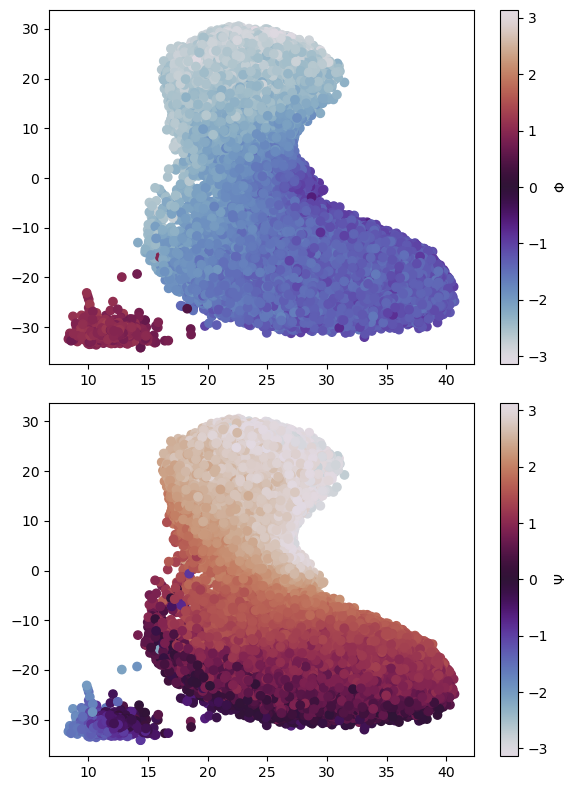

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

sctr = ax[0].scatter(Z[:,0], Z[:, 1], c=data[:, 2], cmap=plt.cm.twilight)
plt.colorbar(sctr, ax=ax[0], label=r'$\Phi$')

sctr = ax[1].scatter(Z[:,0], Z[:, 1], c=data[:, 3], cmap=plt.cm.twilight)
plt.colorbar(sctr, ax=ax[1], label=r'$\Psi$')

plt.tight_layout()

We can compare the above result to the samples plotted in the dihedral angle space. As you can see, all states are represeted in reduced space.

Text(0, 0.5, '$\\Psi$')

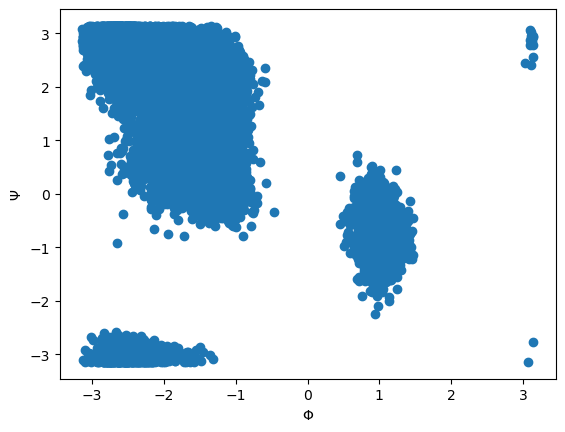

In [17]:
plt.scatter(data[:, 2], data[:, 3])
plt.xlabel(r'$\Phi$')
plt.ylabel(r'$\Psi$')

_Plot training curves from logged results._

In [21]:
run_number = 0

log = pd.read_csv("lightning_logs/version_" + str(run_number) + "/metrics.csv")

In [22]:
log

,epoch,step,train_loss,val_loss
0,0,79,NaN,2.629225
1,0,79,3.197761,NaN
2,1,159,NaN,1.983837
3,1,159,2.211244,NaN
4,2,239,NaN,1.926711
...,...,...,...,...
715,357,28639,1.206807,NaN
716,358,28719,NaN,1.214341
717,358,28719,1.207029,NaN
718,359,28799,NaN,1.214093


Even though we set the maximum number of epochs to 500, the model converged around 350 iterations.

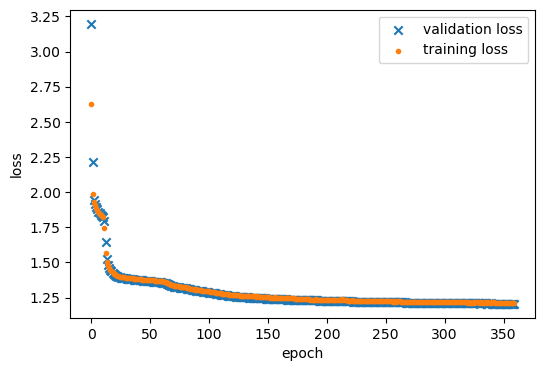

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(log['epoch'], log['train_loss'], label='validation loss', marker='x')
ax.scatter(log['epoch'], log['val_loss'], label='training loss', marker='.')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.legend()